1. Classical CNN

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Create the dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the numpy arrays to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).unsqueeze(1)  # Add an extra dimension for the labels
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).unsqueeze(1)  # Add an extra dimension for the labels

# Create DataLoader for easier batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 6)
        self.fc2 = nn.Linear(6, 16)
        self.dropout = nn.Dropout()
        self.fc3 = nn.Linear(16, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCEWithLogitsLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


Training [5%]	Loss: 0.6797
Training [10%]	Loss: 0.6288
Training [15%]	Loss: 0.5516
Training [20%]	Loss: 0.4601
Training [25%]	Loss: 0.3974
Training [30%]	Loss: 0.3691
Training [35%]	Loss: 0.3704
Training [40%]	Loss: 0.3464
Training [45%]	Loss: 0.3446
Training [50%]	Loss: 0.3464
Training [55%]	Loss: 0.3393
Training [60%]	Loss: 0.3315
Training [65%]	Loss: 0.3525
Training [70%]	Loss: 0.3195
Training [75%]	Loss: 0.3458
Training [80%]	Loss: 0.3380
Training [85%]	Loss: 0.3180
Training [90%]	Loss: 0.3224
Training [95%]	Loss: 0.3220
Training [100%]	Loss: 0.3292


Text(0, 0.5, 'Neg Log Likelihood Loss')

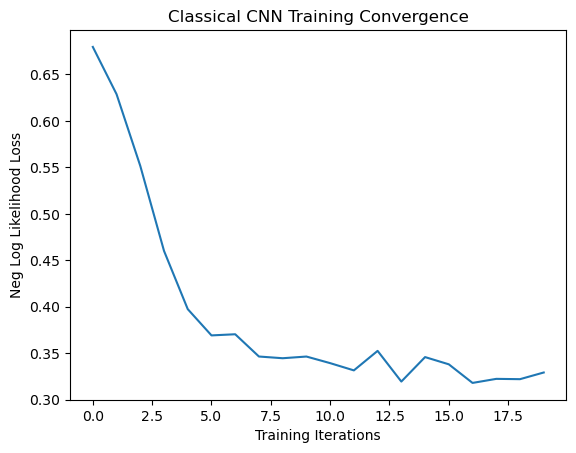

In [84]:
plt.plot(loss_list)
plt.title('Classical CNN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [83]:
model.eval()  # set model to evaluation mode

with torch.no_grad():
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    total_loss = []
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_dataset) * 100
        )
    )


Performance on test data:
	Loss: 0.3048
	Accuracy: 50.0%


2. Quantum CNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit, self.backend)
    
        qiskit_version = qiskit.__version__.split(".")
        if int(qiskit_version[0]) >= 0 and int(qiskit_version[1]) >= 24:
            qobj = assemble(t_qc, shots=self.shots, parameter_binds=[{self.theta: theta} for theta in thetas])
        else:
            qobj = assemble(t_qc, shots=self.shots, parameter_binds=[{self.theta: theta} for theta in thetas])
    
        job = self.backend.run(qobj)
        result = job.result().get_counts()
    
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
    
        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities)
    
        return np.array([expectation])

In [ ]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-yonsei',group="internal",project="datascience")
simulator = provider.get_backend("ibmq_qasm_simulator")

In [ ]:
circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [41]:
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create the dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the numpy arrays to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).unsqueeze(1)  # Add an extra dimension for the labels
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).unsqueeze(1)  # Add an extra dimension for the labels

In [42]:
import json

with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

In [43]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [54]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp

# Define the feature map
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8)

ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Define the observable
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# Create the EstimatorQNN
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

# Create the NeuralNetworkClassifier
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

# Train the model
classifier.fit(X_train, y_train)


TypeError: __init__() missing 2 required positional arguments: 'backend' and 'shots'

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Generate the dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the NumPy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Create TensorDatasets for train and test sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders for train and test sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the modified model
class ModifiedNet(nn.Module):
    def __init__(self):
        super(ModifiedNet, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.hybrid(x)
        return x

# Create an instance of the modified model
model = ModifiedNet()

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Training loop
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss += loss.item() * len(data)
    avg_loss = total_loss / len(train_dataset)
    loss_list.append(avg_loss)
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, avg_loss))

# Evaluation
model.eval()
total_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        total_loss += loss.item() * len(data)
        # Counting correct predictions
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

avg_loss = total_loss / len(test_dataset)
accuracy = 100.0 * correct / total

print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.2f}%'.format(avg_loss, accuracy))


C:\Users\TUF\AppData\Local\Temp\ipykernel_21192\3594688801.py:33: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


TypeError: _run_qobj() got multiple values for argument 'parameter_binds'